# Zebrafish Stimulator Calibration
#### v2 | by M. Zimmermann

This script allows estimating photoceptor excitation caused by LED light sources used in the visual stimulator. To this end, we used a compact CCD Spectrometer (CCS200/M, Thorlabs, Germany) in combination with the Thorlabs Optical Spectrum Analyzers (OSA) software and coupled to a linear fibre patch cable and an optical energy power (PM100D, Thorlabs, Germany) in combination with the Thorlabs Optical Power Monitor (OPM) software and coupled to a photodiode power sensor (S130VC, Thorlabs, Germany). Spectral data was recorded and converted into photoisomerization rates per cone photoreceptor type and LED. 

*__Note:__ This script is used for the tetrachromatic (zebrafish) version of the visual stimulator; it can be easily adapted to other animals with more spectral sensitivites and light source/filter combinations.*

In [1]:
import os
import glob
import math
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import scipy.special as sse
import pylab
from scipy.optimize import curve_fit
from IPython import display

# Helpers
#
import scripts.spectrum as spc
import scripts.progress_bar as pbar
import scripts.spectrometer_helper as spm
import scripts.fitting_funcs as fit

# Set graphics to be plotted in the notebook
#
%matplotlib inline 

# Seaborn plot settings
#
sns.set()

# Paths and file names
# (Don't change unless you know what you are doing)
#
path_LightSources   = "light-sources//"
path_Filters        = "filters//"
path_Data           = "data//"
path_Opsins         = "opsins//"
file_GammaLUT       = "defaultGammaLUT"

txtFileNewLineStr   = "\r\n"

def setPlotStyle():
    # Presettings for figures
    #
    mpl.rcParams['figure.figsize'] = [10, 5]
    mpl.rc('font', size=10)          
    mpl.rc('axes', titlesize=12)    
    mpl.rc('axes', labelsize=12)    
    mpl.rc('xtick', labelsize=12)   
    mpl.rc('ytick', labelsize=12)   
    mpl.rc('legend', fontsize=12)   
    mpl.rc('figure', titlesize=12) 

In [2]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

## Define photoreceptors

Load opsin spectra from text files in the respective folder:

* Text files are expected to have one column per opsin ... 
* ... plus one (the last one) for the scaling in x direction (wavelength, in 1-nm increments).
* All spectral files, including the filter and LED files loaded later, must have the same x range. In this version, 300 .. 699 nm is used.

In [3]:
x_wavelen_nm      = np.loadtxt(path_Opsins +"zebrafish_cone_opsins.txt", usecols=(4,)) # 300 .. 699 nm
zebrafishLOpsin   = np.loadtxt(path_Opsins +"zebrafish_cone_opsins.txt", usecols=(3,))
zebrafishMOpsin   = np.loadtxt(path_Opsins +"zebrafish_cone_opsins.txt", usecols=(2,))
zebrafishSOpsin   = np.loadtxt(path_Opsins +"zebrafish_cone_opsins.txt", usecols=(1,))
zebrafishUVOpsin  = np.loadtxt(path_Opsins +"zebrafish_cone_opsins.txt", usecols=(0,))

Define some properties as well as constants needed later to convert the data measured with the spectrometer into photoisomerizations.

*   `h`: Planck's constant [eV*s]
*   `c`: speed of light [m/s]
*   `eV_per_J`: conversion factor ([eV] per [J])
*   `ac_um2`: cone OS light collection area [µm^2], see [Nikonov et al., 2006] (http://www.ncbi.nlm.nih.gov/pubmed/16567464) for details. This is an experimentally determined value, e.g. for wt mouse cones that is fully dark-adapted, a value of 0.2 can be assumed.

    

In [4]:
h        = 4.135667E-15 # Planck's constant [eV*s]
c        = 299792458    # speed of light [m/s]
eV_per_J = 6.242E+18    # [eV] per [J]
ac_um2   = 0.2     

Organise photoreceptors as a list of dictionaries, with:

*   `name`: name of photoreceptor, used later for plots etc.
*   `peak_nm`: peak wavelength of opsin spectrum in [nm]          
*   `collecArea_um2`: see above
*   `spect`: opsin spectrum

In [5]:
LCone = {"name"           : "zebrafish_L_cone",
         "peak_nm"        : 565,
         "collecArea_um2" : ac_um2, 
         "spect"          : zebrafishLOpsin,
         "spect2"          : []}
MCone = {"name"           : "zebrafish_M_cone",
         "peak_nm"        : 482,
         "collecArea_um2" : ac_um2, 
         "spect"          : zebrafishMOpsin,
         "spect2"          : []}
SCone = {"name"           : "zebrafish_S_cone",
         "peak_nm"        : 411,         
         "collecArea_um2" : ac_um2, 
         "spect"          : zebrafishSOpsin,
         "spect2"          : []}
UVCone = {"name"           : "zebrafish_U_cone",
         "peak_nm"        : 361,
         "collecArea_um2" : ac_um2, 
         "spect"          : zebrafishUVOpsin,
         "spect2"          : []}
PRs   = [LCone, MCone, SCone, UVCone]

Plot cone photoreceptor spectra:

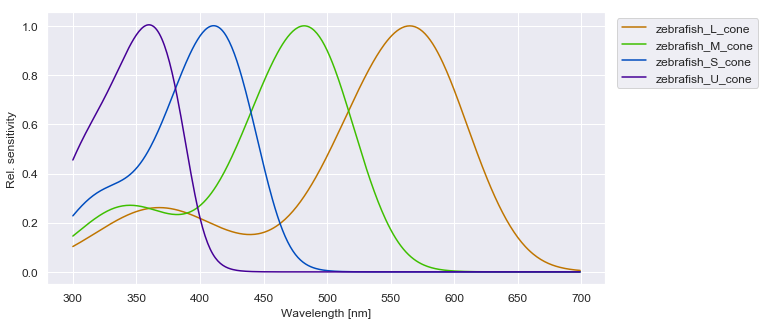

In [6]:
setPlotStyle()

for PR in PRs:
    if len(PR["spect"]) > 0:
        col = spc.wavelength_to_rgb(PR["peak_nm"], darker=0.75)
        plt.plot(x_wavelen_nm, PR["spect"], color=col, label=PR["name"])

plt.gca().set(xlabel="Wavelength [nm]", ylabel="Rel. sensitivity") 
plt.legend(bbox_to_anchor=(1.01, 1), loc="upper left");

## Define stimulus LED/filter combinations 
Load LED and filter (dicroic) spectra from text files in the respective folder. Files are expected to be organised as the photoreceptor data files except that they contain only two columns (relative transmission for filters and relative intensity for light sources; wavelength, from 300 to 699 nm in 1-nm increments).

In [7]:
# LED spectra
#
LED_Red_Name    = "LED_Red_590"
LED_R           = np.loadtxt(path_LightSources +LED_Red_Name +".txt", usecols=(0,))
LED_Green_Name  = "LED_Green_477"
LED_G           = np.loadtxt(path_LightSources +LED_Green_Name +".txt", usecols=(0,))
LED_Blue_Name   = "LED_Blue_415"
LED_B           = np.loadtxt(path_LightSources +LED_Blue_Name +".txt", usecols=(0,))
LED_UV_Name     = "LED_UV_365"
LED_U           = np.loadtxt(path_LightSources +LED_UV_Name +".txt", usecols=(0,))
Wavelgth        = np.loadtxt(path_LightSources +LED_UV_Name +".txt", usecols=(1,))

Wavelength = np.linspace(300,700,400)
LED_Red    = np.interp(Wavelength,Wavelgth,LED_R)
LED_Green  = np.interp(Wavelength,Wavelgth,LED_G)
LED_Blue   = np.interp(Wavelength,Wavelgth,LED_B)
LED_UV     = np.interp(Wavelength,Wavelgth,LED_U)

In [8]:
# LED filter(s)
#
Filter_UV_Name      = "F39-370"
Filter_U            = np.loadtxt(path_Filters +Filter_UV_Name +".txt", dtype=np.str, usecols=(1,))
Filter_Blue_Name    = "F47-420"
Filter_B            = np.loadtxt(path_Filters +Filter_Blue_Name +".txt", dtype=np.str, usecols=(1,))
Filter_Green_Name   = "F49-480"
Filter_G            = np.loadtxt(path_Filters +Filter_Green_Name +".txt", dtype=np.str, usecols=(1,))
Filter_Red_Name     = "F39-587"
Filter_R            = np.loadtxt(path_Filters +Filter_Red_Name +".txt", dtype=np.str, usecols=(1,))

waveR               = np.loadtxt(path_Filters +Filter_Red_Name +".txt", dtype=np.str, usecols=(0,))
waveG               = np.loadtxt(path_Filters +Filter_Green_Name +".txt", dtype=np.str, usecols=(0,))
waveB               = np.loadtxt(path_Filters +Filter_Blue_Name +".txt", dtype=np.str, usecols=(0,))
waveU               = np.loadtxt(path_Filters +Filter_UV_Name +".txt", dtype=np.str, usecols=(0,))
wavelength = waveG

In [9]:
F_Red = []
W_Red = []
for i in range(len(waveR)):
    r = Filter_R[i].replace(',','.')
    wr = waveR[i].replace(',','.')
    rr = float(r)
    wwr = float(wr)
    F_Red.append(rr)
    W_Red.append(wwr)

Fi_Red = F_Red [150:]
WaveR = W_Red [150:]
Filter_Red = []
WaveRed = []
for i in range (len(waveR)-150):
    if i%5 == 0:
        Filter_Red.append(Fi_Red[i])
        WaveRed.append(WaveR[i])
    
Filter_Green = []
WaveGreen = []
for i in range (len(waveG)):
    g = Filter_G[i].replace(',','.')
    wg = waveG[i].replace(',','.')
    gg = float(g)
    wwg = float(wg)
    Filter_Green.append(gg)
    WaveGreen.append(wwg)    

Filter_Blue = []
WaveBlue = []
for i in range (len(waveG)):
    b = Filter_B[i].replace(',','.')
    wb = waveB[i].replace(',','.')
    bb = float(b)
    wwb = float(wb)
    bbb = np.divide(bb,100)
    Filter_Blue.append(bbb)
    WaveBlue.append(wwb)
    
F_UV = []
W_UV = []
for i in range(len(waveU)):
    u = Filter_U[i].replace(',','.')
    wu = waveU[i].replace(',','.')
    uu = float(u)
    wwu = float(wu)
    F_UV.append(uu)
    W_UV.append(wwu)

Filter_UV = []
WaveUV = []
for i in range (len(waveU)):
    if i%5 == 0:
        Filter_UV.append(F_UV[i])
        WaveUV.append(W_UV[i])

Organise the LED/filter combinations and spectra as a list of dictionary, with:  
*   `name`: name of LED/filter combinations, used later for plots etc.
*   `peak_nm`: peak wavelength of LED/filter combination in [nm]          
*   `LED_spect`: spectrum of LED (same x range as the opsin spectra, that is from 300 to 699 nm, and with 1-nm resolution).
*   `filter_spect`: spectrum of filter
*   `power`: measured LED/filter spectrum in [nW]
*   `power_norm`: `power` measured LED/filter spectrum in [nW]-normalized
*   `LED_power`: list of fits of mean LED/filter spectra for all intensity levels

In [10]:
UVLED = {"name"         : "UV_LED",
         "peak_nm"      : 361,          # 0=determine from peak
         "target_PR"    : "zebrafish_U_cone",
         "LED_spect"    : LED_UV,       # LED spectrum (datasheet)
         "filter_spect" : Filter_UV,    # filter spectrum (datasheet)
         "power"        : None,
         "power_norm"   : None,
         "LED_power"    : None}  

BlLED = {"name"         : "Blue_LED",
         "peak_nm"      : 411,          # 0=determine from peak
         "target_PR"    : "zebrafish_S_cone",
         "LED_spect"    : LED_Blue,     # LED spectrum (datasheet)
         "filter_spect" : Filter_Blue,  # filter spectrum (datasheet)
         "power"        : None,
         "power_norm"   : None,
         "LED_power"    : None} 

GrLED = {"name"         : "Green_LED",
         "peak_nm"      : 482,          # 0=determine from peak
         "target_PR"    : "zebrafish_M_cone",
         "LED_spect"    : LED_Green,    # LED spectrum (datasheet)
         "filter_spect" : Filter_Green, # filter spectrum (datasheet)
         "power"        : None,
         "power_norm"   : None,
         "LED_power"    : None}   

ReLED = {"name"         : "Red_LED",
         "peak_nm"      : 565,
         "target_PR"    : "zebrafish_L_cone",
         "LED_spect"    : LED_Red,
         "filter_spect" : Filter_Red,        
         "power"        : None,
         "power_norm"   : None,
         "LED_power"    : None}

LEDs = [ReLED, GrLED, BlLED, UVLED]         

Plot theoretical spectra of LED/filter combinations together with cone photoreceptors:

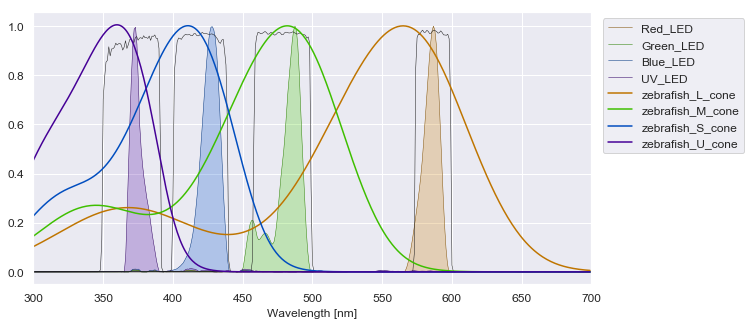

In [11]:
for LED in LEDs:  
    if len(LED["LED_spect"]) == 0: 
        continue
    
    col_lo = spc.wavelength_to_rgb(LED["peak_nm"], darker=0.5)
    col_hi = spc.wavelength_to_rgb(LED["peak_nm"], darker=0.8)
    plt.plot(Wavelength, LED["LED_spect"], color=col_lo, 
             label=LED["name"], linewidth=0.5)
    plt.fill(Wavelength, LED["LED_spect"], facecolor=col_hi, alpha=0.25)  
    
    
plt.plot(WaveRed,Filter_Red,'k',linewidth=0.5)
plt.plot(WaveGreen,Filter_Green,'k',linewidth=0.5)
plt.plot(WaveBlue,Filter_Blue,'k',linewidth=0.5)
plt.plot(WaveUV,Filter_UV,'k',linewidth=0.5)

    
for PR in PRs:
    if len(PR["spect"]) > 0:
        col = spc.wavelength_to_rgb(PR["peak_nm"], darker=0.75)
        plt.plot(x_wavelen_nm, PR["spect"], color=col, label=PR["name"])

plt.gca().set(xlabel="Wavelength [nm]", ylabel="") 
plt.legend(bbox_to_anchor=(1.01, 1), loc="upper left")
plt.xlim((300,700));

# Extract Powermeter Recording to determine the electrical power (in nW)
Here, we used an optical energy power (PM100D, Thorlabs, Germany) in combination with the Thorlabs Optical Power Monitor (OPM) software and coupled to a photodiode power sensor (S130VC, Thorlabs, Germany).


The following script is configured by default for ThorLab Powermeter recording in .csv format. If a different spectrometer is used, the general parameters below need to be modified

In [12]:
'''Powermeter Recording General Parameters'''
Steps = 255                                             # Set the number of recording points for each LED
Red_FirstRecording = 28                                 # Set for the Red recording the first recording point
Red_LastRecording = Red_FirstRecording + Steps
Green_FirstRecording = 24                               # Set for the Green recording the first recording point
Green_LastRecording = Green_FirstRecording + Steps
Blue_FirstRecording = 24                                # Set for the Blue recording the first recording point
Blue_LastRecording = Blue_FirstRecording + Steps
UV_FirstRecording = 31                                  # Set for the UV recording the first recording point
UV_LastRecording = UV_FirstRecording + Steps

Red_FileName = path_Data + 'Red.csv'                    # Import the Red recording (Red.csv has to be the name of the recording csv file)
Green_FileName = path_Data + 'Green.csv'                # Import the Green recording (Red.csv has to be the name of the recording csv file)
Blue_FileName = path_Data + 'Blue.csv'                  # Import the Blue recording (Red.csv has to be the name of the recording csv file)
UV_FileName = path_Data + 'UV.csv'                      # Import the UV recording (Red.csv has to be the name of the recording csv file)

### Plot Energy readings for each LED 

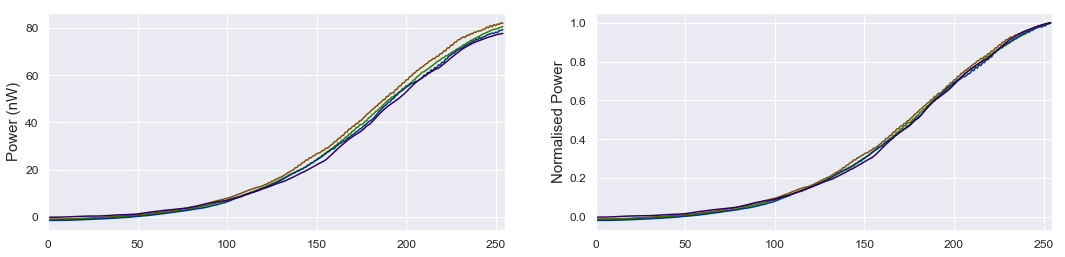

In [13]:
powermeter_red = pd.read_csv(Red_FileName, sep = ';',skiprows = Red_FirstRecording, header = None, names = ['number','time','power'])
Power_red = np.asarray(powermeter_red.power)[:Steps]*10**9

powermeter_green = pd.read_csv(Green_FileName, sep = ';',skiprows = Green_FirstRecording, header = None, names = ['number','time','power'])
Power_green = np.asarray(powermeter_green.power)[:Steps]*10**9

powermeter_blue= pd.read_csv(Blue_FileName, sep = ';',skiprows = Blue_FirstRecording, header = None, names = ['number','time','power'])
Power_blue = np.asarray(powermeter_blue.power)[:Steps]*10**9

powermeter_uv = pd.read_csv(UV_FileName, sep = ';',skiprows = UV_FirstRecording, header = None, names = ['number','time','power'])
Power_uv = np.asarray(powermeter_uv.power)[:Steps]*10**9

stim_intens = np.arange(Steps)

def normalise (myarray):
    myarray = myarray/np.nanmax(np.abs(myarray))
    return myarray

norm_power_red = normalise(Power_red)
norm_power_green = normalise(Power_green)
norm_power_blue = normalise(Power_blue)
norm_power_uv = normalise(Power_uv)

Power = np.zeros((len(LEDs),Steps))
Power = (Power_red,Power_green,Power_blue,Power_uv)

Norm_Power = np.zeros((len(LEDs),Steps))
Norm_Power = (norm_power_red,norm_power_green,norm_power_blue,norm_power_uv)

y_Steps = np.arange(0,Steps,1)
fig,ax = plt.subplots(1,2,figsize = (18,4))

colour = []

for iLED, LED in enumerate(LEDs):
    LED["power"] = []
    LED["power_norm"] = []
    col = spc.wavelength_to_rgb(LED["peak_nm"], darker=0.5) 
    colour.append(col)
    for iI, Intens in enumerate(stim_intens):
        LED["power"].append(Power[iLED][iI])
        LED["power_norm"].append(Norm_Power[iLED][iI])

for iLED in range (len(LEDs)):
    ax[0].plot(y_Steps,Power[iLED],c=colour[iLED])
    ax[1].plot(y_Steps,Norm_Power[iLED],c=colour[iLED])

ax[0].set_ylabel('Power (nW)', fontsize = 15)
ax[0].set_xlim(0,255);

ax[1].set_ylabel('Normalised Power', fontsize = 15);
ax[1].set_xlim(0,255);


### Define measurement parameters
For the measurement and later for the calculation of photoisomerization rates, the area (`A_detect_um2`) of the measured light spot -- or, if it overfills the sensor of the powermeter, the area of the sensor (e.g. the diffusor window of the powermeter) -- is needed.  


*__Note:__ In case of the  photodiode power sensor (S130VC, Thorlabs, Germany) used here, the area of the diffusor window is 0.95cm².*  
*__Note:__ The integration time should be changed if output is saturated*

In [14]:
r_stimulus_um = (9.5/2)*1000   

# Some calculations ...
#
A_detect_um2 = np.pi*(r_stimulus_um)**2
print("Illuminated area is {0:.3e} µm2 (= {1:.3} cm²)".format(A_detect_um2, A_detect_um2 *1E-8))

Illuminated area is 7.088e+07 µm2 (= 0.709 cm²)


Plot calibrated (fitted) spectra of LED/filter combinations together with the photoreceptor opsin sensitivity curves and the filter spectra from the datasheets:

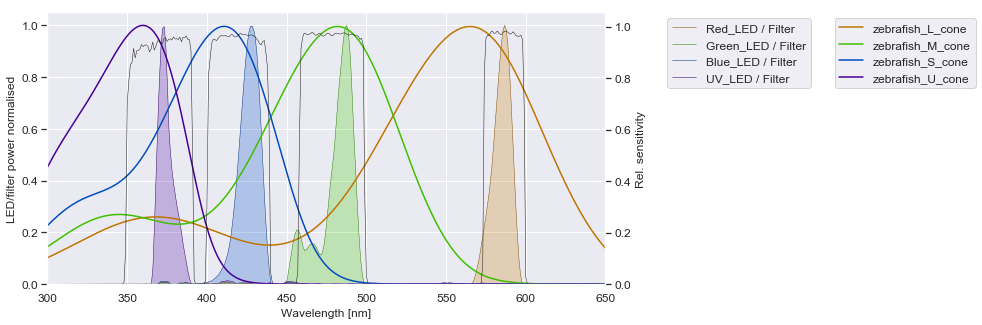

In [15]:
fig, ax1 = plt.subplots()
ax2      = ax1.twinx()  

for iLED, LED in enumerate(LEDs):
    col_lo = spc.wavelength_to_rgb(LED["peak_nm"], darker=0.5)
    col_hi = spc.wavelength_to_rgb(LED["peak_nm"], darker=0.8)   
    tempLbl = LED["name"] +" / Filter" 
    ax1.plot(Wavelength, LED["LED_spect"], color=col_lo, label=tempLbl, linewidth=0.5)
    ax1.fill(Wavelength, LED["LED_spect"], facecolor=col_hi, alpha=0.25)    
    
for PR in PRs:
    if len(PR["spect"]) > 0:
        col = spc.wavelength_to_rgb(PR["peak_nm"], darker=0.75)
        ax2.plot(x_wavelen_nm, PR["spect"], color=col, label=PR["name"])

ax1.set_xlabel("Wavelength [nm]")        
ax1.set_ylabel("LED/filter power normalised")   
ax1.legend(bbox_to_anchor=(1.10, 1), loc="upper left")
ax1.set_ylim(bottom=0)

plt.plot(WaveRed,Filter_Red,'k',linewidth=0.5)
plt.plot(WaveGreen,Filter_Green,'k',linewidth=0.5)
plt.plot(WaveBlue,Filter_Blue,'k',linewidth=0.5)
plt.plot(WaveUV,Filter_UV,'k',linewidth=0.5)

ax2.set_ylabel("Rel. sensitivity")        
ax2.legend(bbox_to_anchor=(1.40, 1), loc="upper left")
ax2.set_ylim(bottom=0)
ax2.grid(False)
ax2.set_xlim((300, 650));

Red_LED, sum = 1.114e+02 nW
Green_LED, sum = 1.202e+02 nW
Blue_LED, sum = 9.832e+01 nW
UV_LED, sum = 7.583e+01 nW


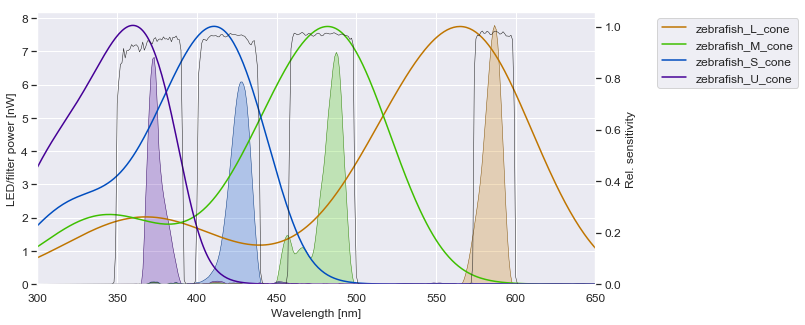

In [16]:
fig, ax1 = plt.subplots()
ax2      = ax1.twinx()

for PR in PRs:
    if len(PR["spect"]) > 0:
        col = spc.wavelength_to_rgb(PR["peak_nm"], darker=0.75)
        ax2.plot(x_wavelen_nm, PR["spect"], color=col, label=PR["name"])
             
LED["LED_power"] = []
for LED in LEDs:
    if len(LED["LED_spect"]) > 0:
        col_lo = spc.wavelength_to_rgb(LED["peak_nm"], darker=0.5)
        col_hi = spc.wavelength_to_rgb(LED["peak_nm"], darker=0.8)
        ax1.plot(Wavelength, LED["LED_spect"]*LED["power"][99], color=col_lo, label=LED["name"], linewidth=0.5)
        ax1.fill(Wavelength, LED["LED_spect"]*LED["power"][99], facecolor=col_hi, alpha=0.25) 
        LED["LED_power"] = sum(LED["LED_spect"]*LED["power"][99])
                    
ax1.set_xlabel("Wavelength [nm]")        
ax1.set_ylabel("LED/filter power [nW]")   
ax1.set_ylim(bottom=0)

plt.plot(WaveRed,Filter_Red,'k',linewidth=0.5)
plt.plot(WaveGreen,Filter_Green,'k',linewidth=0.5)
plt.plot(WaveBlue,Filter_Blue,'k',linewidth=0.5)
plt.plot(WaveUV,Filter_UV,'k',linewidth=0.5)

ax2.set_ylabel("Rel. sensitivity")        
ax2.set_ylim(bottom=0)
ax2.legend(bbox_to_anchor=(1.10, 1), loc="upper left")
ax2.grid(False)
ax2.set_xlim((300, 650));

for iLED, LED in enumerate(LEDs):
    print("{0}, sum = {1:.3e} nW".format(LED["name"], LED["LED_power"]))



## Determine effective photoreceptor stimulation

Calculate spectra for effective LED/filter combinations ...

In [17]:
for LED in LEDs:
    LED["effect_on_PR"] = []
    for PR in PRs:
        if len(PR["spect"]) > 0:
            temp = {}
            temp["PR_name"] = PR["name"]
            temp["spect"]   = []
            temp["rel_exc"] = []
            for iI, Intens in enumerate(stim_intens):    
                tempSpect   = np.array(PR["spect"] *LED["LED_spect"])
                temp["spect"].append(tempSpect)
                A_overlap   = np.trapz(tempSpect)
                A_LED       = np.trapz(LED["LED_spect"])
                rel_exc     = A_overlap / A_LED if (A_LED > 0) else 0.0
                temp["rel_exc"].append(rel_exc)
            LED["effect_on_PR"].append(temp)










## Generate summary (maximal isomerization rates)

1. Plot (normalized) spectra of photoreceptors and LED/filter combinations and print relative co-excitation of photoreceptors by the LEDs.

2. Calculate and print photo-isomerization rates for all LED/filter and photoreceptor combinations

Relative co-excitation (at intensity=254):
  89.9% of zebrafish_L_cone by Red_LED
   2.5% of zebrafish_M_cone by Red_LED
   1.2% of zebrafish_S_cone by Red_LED
   0.5% of zebrafish_U_cone by Red_LED
  31.0% of zebrafish_L_cone by Green_LED
  96.0% of zebrafish_M_cone by Green_LED
   7.5% of zebrafish_S_cone by Green_LED
   0.3% of zebrafish_U_cone by Green_LED
  17.1% of zebrafish_L_cone by Blue_LED
  47.8% of zebrafish_M_cone by Blue_LED
  87.2% of zebrafish_S_cone by Blue_LED
   2.0% of zebrafish_U_cone by Blue_LED
  26.8% of zebrafish_L_cone by UV_LED
  24.6% of zebrafish_M_cone by UV_LED
  64.9% of zebrafish_S_cone by UV_LED
  81.7% of zebrafish_U_cone by UV_LED


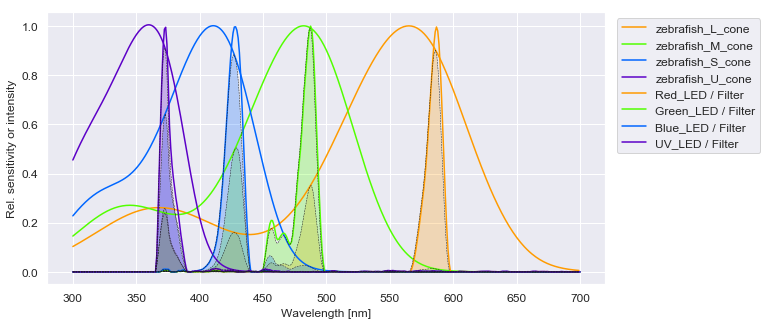

Maximal photoisomerization rates (at intensity=254):
   87.1 10^2 photons/s in zebrafish_L_cone for Red_LED
    2.4 10^2 photons/s in zebrafish_M_cone for Red_LED
    1.1 10^2 photons/s in zebrafish_S_cone for Red_LED
    0.5 10^2 photons/s in zebrafish_U_cone for Red_LED
   29.4 10^2 photons/s in zebrafish_L_cone for Green_LED
   91.1 10^2 photons/s in zebrafish_M_cone for Green_LED
    7.1 10^2 photons/s in zebrafish_S_cone for Green_LED
    0.3 10^2 photons/s in zebrafish_U_cone for Green_LED
   13.3 10^2 photons/s in zebrafish_L_cone for Blue_LED
   37.2 10^2 photons/s in zebrafish_M_cone for Blue_LED
   67.7 10^2 photons/s in zebrafish_S_cone for Blue_LED
    1.5 10^2 photons/s in zebrafish_U_cone for Blue_LED
   12.5 10^2 photons/s in zebrafish_L_cone for UV_LED
   11.5 10^2 photons/s in zebrafish_M_cone for UV_LED
   30.3 10^2 photons/s in zebrafish_S_cone for UV_LED
   38.1 10^2 photons/s in zebrafish_U_cone for UV_LED


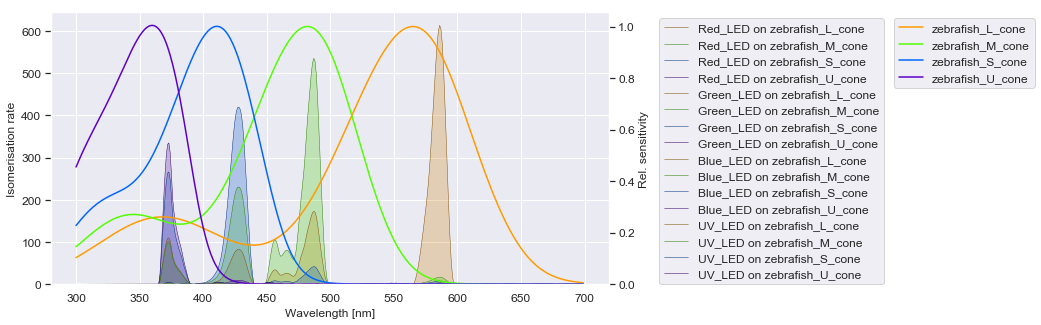

In [18]:
# Plot (normalized) spectra of photoreceptors and LED/filter combinations
#
for PR in PRs:
    if len(PR["spect"]) > 0:
        plt.plot(x_wavelen_nm, PR["spect"], 
                 color=spc.wavelength_to_rgb(PR["peak_nm"]), label=PR["name"])
        
for LED in LEDs:        
    colLED = spc.wavelength_to_rgb(LED["peak_nm"])
    if len(LED["power_norm"]) > 0:    
        plt.plot(Wavelength, LED["LED_spect"]*LED["power_norm"][-1], color=colLED, label=LED["name"] +" / Filter")
        for effect in LED["effect_on_PR"]:
            for PR in PRs:
                if PR["name"] == effect["PR_name"]:
                    colPR = spc.wavelength_to_rgb(PR["peak_nm"],)
            plt.plot(x_wavelen_nm, effect["spect"][-1], "k--",linewidth=0.5)        
            plt.fill(x_wavelen_nm, effect["spect"][-1], facecolor=colPR, alpha=0.25)    

plt.gca().set(xlabel="Wavelength [nm]", ylabel="Rel. sensitivity or intensity")     
plt.legend(bbox_to_anchor=(1.01, 1), loc="upper left")

# Print co-excitation values for all LED/filter and photoreceptor combinations
#
print("Relative co-excitation (at intensity={0}):".format(stim_intens[-1]))
for LED in LEDs:        
    if len(LED["power_norm"]) > 0:    
        for effect in LED["effect_on_PR"]:
            print("{0:6.1f}% of {1} by {2}"
                  .format(effect["rel_exc"][-1]*100, effect["PR_name"], LED["name"]))    
plt.show()

# Calculate and print photo-isomerization rates for all LED/filter and 
# photoreceptor combinations
#            
for iLED, LED in enumerate(LEDs):
    LED["pow_eflux"] = []
    LED["pow_Q"]     = []
    LED["pow_phi"]   = []
    LED["pow_E"]     = []
    
    for iI, Intens in enumerate(stim_intens):    
        # Convert energy flux from [nW] (=readout of spectrometer) into [eV/s]
        #
        pow_eflux = np.array((LED["LED_spect"]*LED["power"][iI] *1E-9 *eV_per_J), dtype=float)
    
        # Calculate the wavelength-dependent photon energy `Q` in [eV]
        #
        pow_Q     = np.array((c*h/(x_wavelen_nm *1E-9)), dtype=float)
    
        # Divide energy flux by the photon energy to get the photon flux `phi`[photons/s] 
        # and then photon flux density `E` [photons/s /µm^2]
        #
        pow_phi   = np.divide(pow_eflux, pow_Q)
        pow_E     = pow_phi /A_detect_um2
    
        LED["pow_eflux"].append(pow_eflux)
        LED["pow_Q"].append(pow_Q)
        LED["pow_phi"].append(pow_phi)
        LED["pow_E"].append(pow_E)
    
    # Calculate per photoreceptor ...
    #
    for effect in LED["effect_on_PR"]:
        for iPR, PR in enumerate(PRs):
            if PR["name"] == effect["PR_name"]:
                effect["photon_rate"]         = []
                effect["photoiso_rate"]       = []
                effect["photoiso_rate_total"] = []
                
                for iI, Intens in enumerate(stim_intens):    
                    # ... photon flux per photoreceptor `photon_rate` in [photons/s]
                    #
                    A_collect   = PR["collecArea_um2"]
                    photon_rate = LED["pow_E"][iI] *A_collect           
                
                    # ... photoisomerizations [P*/photoreceptor /s]
                    #
                    photoiso_rate       = photon_rate *effect["rel_exc"][iI]
                    photoiso_rate_total = np.sum(photoiso_rate)
                
                    effect["photon_rate"].append(photon_rate) 
                    effect["photoiso_rate"].append(photoiso_rate) 
                    effect["photoiso_rate_total"].append(photoiso_rate_total) 
                
                if (iLED == 0) and (iPR == 0): 
                    print("Maximal photoisomerization rates (at intensity={0}):".format(stim_intens[-1]))
                    
                print("{0:7.1f} 10^2 photons/s in {1} for {2}"
                     .format(effect["photoiso_rate_total"][-1]/1E2, PR["name"], LED["name"]))

# Plot ...
#
fig, ax1 = plt.subplots()
ax2      = ax1.twinx()

for PR in PRs:
    if len(PR["spect"]) > 0:
        ax2.plot(x_wavelen_nm, PR["spect"], 
                 color=spc.wavelength_to_rgb(PR["peak_nm"]), label=PR["name"])

for LED in LEDs:
    for effect in LED["effect_on_PR"]:
        for iPR, PR in enumerate(PRs):
            if PR["name"] == effect["PR_name"]:
                col_lo = spc.wavelength_to_rgb(PR["peak_nm"], darker=0.5)
                col_hi = spc.wavelength_to_rgb(PR["peak_nm"], darker=0.8)
                ax1.plot(x_wavelen_nm, effect["photoiso_rate"][-1], color=col_lo, 
                         label=LED["name"] +" on " +PR["name"], linewidth=0.5)
                ax1.fill(x_wavelen_nm, effect["photoiso_rate"][-1], facecolor=col_hi, alpha=0.25)        

ax1.set_xlabel("Wavelength [nm]")        
ax1.set_ylabel("Isomerisation rate")   
ax1.legend(bbox_to_anchor=(1.08, 1), loc="upper left")
ax1.set_ylim(bottom=0)

ax2.set_ylabel("Rel. sensitivity")        
ax2.legend(bbox_to_anchor=(1.50, 1), loc="upper left")
ax2.set_ylim(bottom=0)
ax2.grid(False)

## Intensity curves and gamma function

Plot photoisomerisation rates as a function of light source (LED/filter) intensities.

*__Note:__* This part is largely specific for the mouse version of our visual stimulator and our stimulation software ([QDSpy](https://github.com/eulerlab/QDSpy)); it focusses on two LEDs, a UV and a green one, and may serve as an example for stimulation solutions.

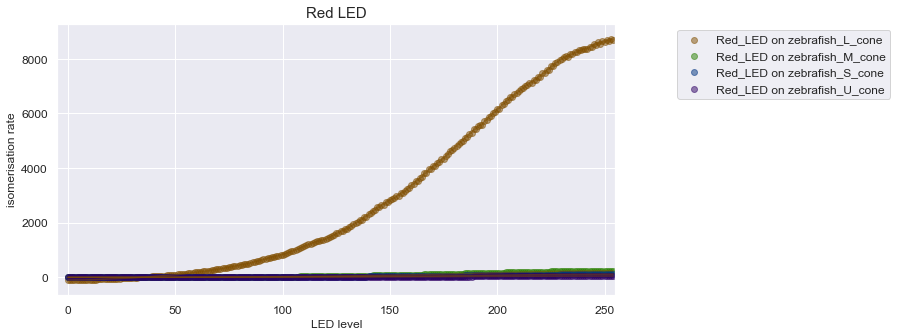

In [19]:
for LED in LEDs[0:1]:
    for iE, effect in enumerate(LED["effect_on_PR"]):
        for iPR, PR in enumerate(PRs):
            if PR["name"] == effect["PR_name"]:
                col_lo  = spc.wavelength_to_rgb(PR["peak_nm"], darker=0.5)
                col_LED = spc.wavelength_to_rgb(LED["peak_nm"], darker=0.5)
                tempLbl = LED["name"] +" on " +PR["name"] if iE <= 3 else ""
                plt.plot(np.array(stim_intens), effect["photoiso_rate_total"], color=col_LED, alpha=0.5)
                plt.scatter(np.array(stim_intens), effect["photoiso_rate_total"], color=col_lo, alpha=0.5, 
                            label=tempLbl)

plt.title('Red LED', fontsize = 15)                
plt.gca().set(xlabel="LED level", ylabel="isomerisation rate")     
plt.legend(bbox_to_anchor=(1.10, 1.0), loc="upper left")                
plt.xlim((-5, 255));

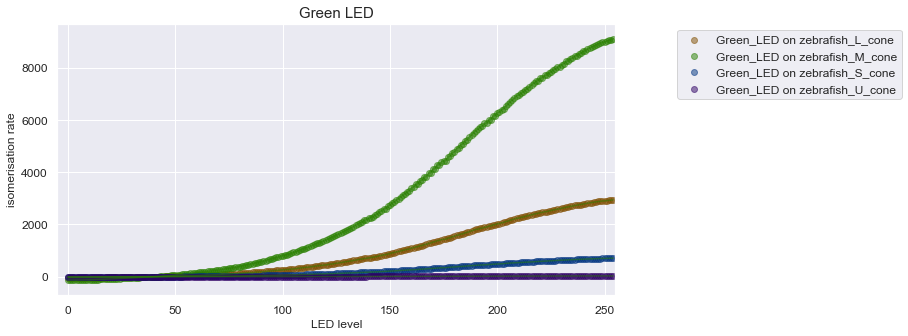

In [20]:
for LED in LEDs[1:2]:
    for iE, effect in enumerate(LED["effect_on_PR"]):
        for iPR, PR in enumerate(PRs):
            if PR["name"] == effect["PR_name"]:
                col_lo  = spc.wavelength_to_rgb(PR["peak_nm"], darker=0.5)
                col_LED = spc.wavelength_to_rgb(LED["peak_nm"], darker=0.5)
                tempLbl = LED["name"] +" on " +PR["name"] if iE <= 3 else ""
                plt.plot(np.array(stim_intens), effect["photoiso_rate_total"], color=col_LED, alpha=0.5)
                plt.scatter(np.array(stim_intens), effect["photoiso_rate_total"], color=col_lo,alpha=0.5, 
                            label=tempLbl)
plt.title('Green LED', fontsize = 15)
plt.gca().set(xlabel="LED level", ylabel="isomerisation rate")     
plt.legend(bbox_to_anchor=(1.10, 1.0), loc="upper left")                
plt.xlim((-5, 255));

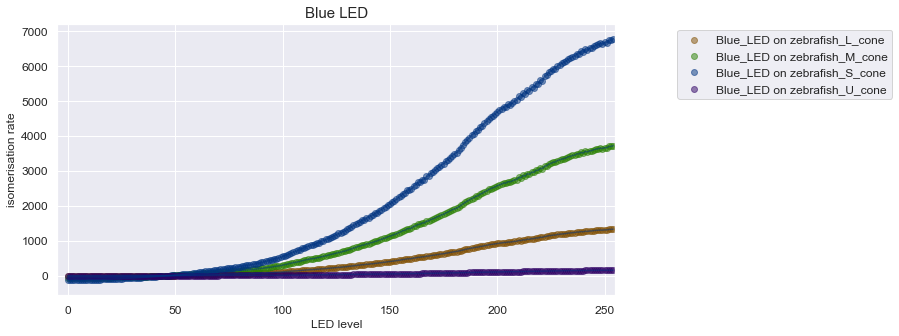

In [21]:
for LED in LEDs[2:3]:
    for iE, effect in enumerate(LED["effect_on_PR"]):
        for iPR, PR in enumerate(PRs):
            if PR["name"] == effect["PR_name"]:
                col_lo  = spc.wavelength_to_rgb(PR["peak_nm"], darker=0.5)
                col_LED = spc.wavelength_to_rgb(LED["peak_nm"], darker=0.5)
                tempLbl = LED["name"] +" on " +PR["name"] if iE <= 3 else ""
                plt.plot(np.array(stim_intens), effect["photoiso_rate_total"], color=col_LED, alpha=0.5)
                plt.scatter(np.array(stim_intens), effect["photoiso_rate_total"], color=col_lo,alpha=0.5, 
                            label=tempLbl)
plt.title('Blue LED', fontsize = 15)
plt.gca().set(xlabel="LED level", ylabel="isomerisation rate")     
plt.legend(bbox_to_anchor=(1.10, 1.0), loc="upper left")                
plt.xlim((-5, 255));

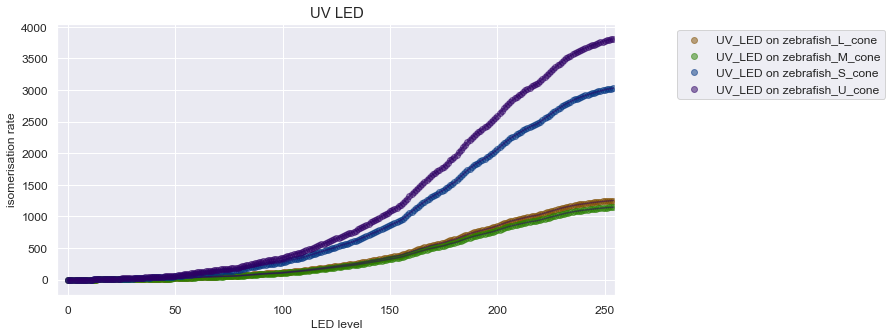

In [22]:
for LED in LEDs[3:4]:
    for iE, effect in enumerate(LED["effect_on_PR"]):
        for iPR, PR in enumerate(PRs):
            if PR["name"] == effect["PR_name"]:
                col_lo  = spc.wavelength_to_rgb(PR["peak_nm"], darker=0.5)
                col_LED = spc.wavelength_to_rgb(LED["peak_nm"], darker=0.5)
                tempLbl = LED["name"] +" on " +PR["name"] if iE <= 3 else ""
                plt.plot(np.array(stim_intens), effect["photoiso_rate_total"], color=col_LED, alpha=0.5)
                plt.scatter(np.array(stim_intens), effect["photoiso_rate_total"], color=col_lo, alpha=0.5, 
                            label=tempLbl)
plt.title('UV LED', fontsize = 15)
plt.gca().set(xlabel="LED level", ylabel="isomerisation rate")     
plt.legend(bbox_to_anchor=(1.10, 1.0), loc="upper left")                
plt.xlim((-5, 255));

Fit sigmoid to isomerisation curves:

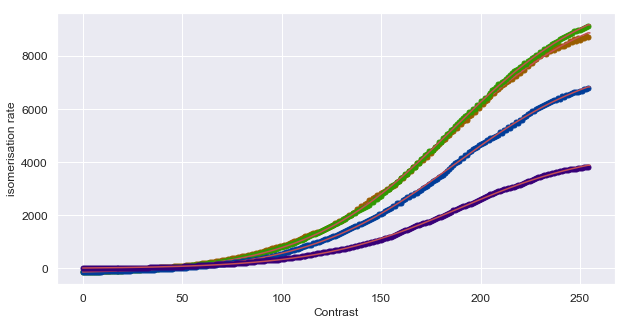

In [23]:
aa=[]
for iLED, LED in enumerate(LEDs):
    LED["intensity_curve_fit"] = []
    for iPR, PR in enumerate(PRs):
        if PR["name"] == LED["target_PR"]:
            
            current_rate = LEDs[iLED]["effect_on_PR"][iPR]["photoiso_rate_total"]
            current_rate = np.array(current_rate)
            aa.append(current_rate)
            
            stim_intens  = np.array(stim_intens)
            nP           = stim_intens.shape
            stim_steps   = np.linspace(0, nP[0], nP[0])
            
            popt, pcov   = curve_fit(fit.Sigmoid, stim_steps, current_rate)
            
            x            = np.linspace(0, nP[0], nP[0])
            current_fit  = fit.Sigmoid(x, *popt)
            current_fit  = np.array(current_fit)
            
            stim_intens_int = np.linspace(0, 255, 256)
            current_fit_int = np.interp(stim_intens_int,stim_intens,current_fit)
            
            LED["intensity_curve_fit"].append(current_fit_int)
            
            col_lo  = spc.wavelength_to_rgb(LED["peak_nm"], darker=0.6)
            plt.plot(stim_intens,current_rate,marker="o", color = col_lo, markersize=5)
            plt.plot(stim_intens_int,current_fit_int, color="r")
            plt.xlabel("Contrast")
            plt.ylabel("isomerisation rate")

Calculate correction curve for all LEDs:

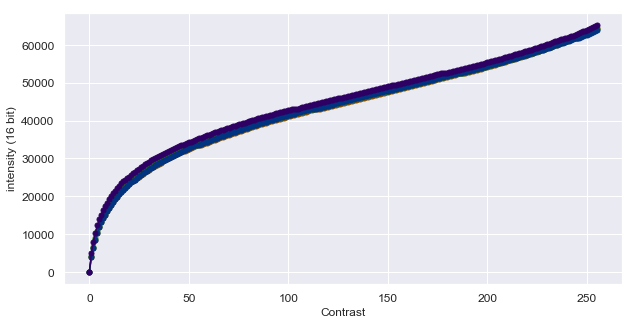

In [24]:
for iLED, LED in enumerate(LEDs):
    LED["correction_curve"] = []
    for iPR, PR in enumerate(PRs):
        if PR["name"] == LED["target_PR"]:
            
            current_fit = LED["intensity_curve_fit"][0]
            current_fit = np.array(current_fit)

            line        = [min(current_fit) +i/len(current_fit)*max(current_fit) for i in range(len(current_fit))]
            LUT         = np.copy(current_fit)
            nP          = current_fit.shape[0]
            
            for iLev in range(nP):
                current_level, = np.where(current_fit>=line[iLev])
                if current_level.shape[0] == 0:
                    LUT[iLev] = LUT[iLev-1]
                else:
                    LUT[iLev] = current_level[0]
            
            LUT_final = [int(v/255.0* (pow(2,16)-1)) for v in LUT]
            LED["correction_curve"].append(LUT_final)
            
            col_lo  = spc.wavelength_to_rgb(LED["peak_nm"], darker=0.5)
            plt.plot(LUT_final, color=col_lo, marker="o", markersize=5)
            plt.xlabel("Contrast")
            plt.ylabel("intensity (16 bit)")

Generate gamma table for export (to [QDSpy](https://github.com/eulerlab/QDSpy)).  
Note that the previous `defaultGammaLUT.txt` file is not overwritten, instead a new version is created.

In [25]:
# Initialize table
#
RGB         = ["none", LEDs[0]["name"], LEDs[1]["name"]]
gamma_table = []

# Generate table
#
for iN, N in enumerate(RGB):
    if RGB[iN] == "none":
        current_LUT = np.transpose([int(v+1)*256-1 for v in range(256)])
        gamma_table.append(current_LUT)
    else:
        for iLED, LED in enumerate(LEDs):
            if LED["name"] == RGB[iN]:
                current_LUT = np.array(LED["correction_curve"][0])
                gamma_table.append(current_LUT)

# Generate a new file name to avoid overwriting earlier versions ...
#
fName = path_Data +file_GammaLUT +".txt"
i     = 1
while os.path.isfile(fName):
    fName = "{0}{1}_{2:d}.txt".format(path_Data, file_GammaLUT, i)
    i += 1
    
# ... and write gamma LUT to disk
#
np.savetxt(fName, np.transpose(gamma_table), fmt="%d", delimiter=', ', newline=txtFileNewLineStr)
print("Gamma LUT written to `{0}`.".format(fName))

Gamma LUT written to `data//defaultGammaLUT.txt`.
